In [1]:
import os
import sys
def getRepoPath():
    cwd = os.getcwd()
    delimiter = "\\" if "\\" in cwd else "/"
    repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
    return repoPath
repoPath = getRepoPath()
sys.path.append(repoPath + 'dataImport/')
from utils import workingDataPath, getWorkingHRDfParquet, getHRGroups, calcIntersectionOfMultipleGroups, getHRsForTimePeriods, graphMultiHRDate, graphHypnoandHRDate
import pandas as pd
from datetime import date, time, timedelta

/home/chowder/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
appleHRDf = getWorkingHRDfParquet('apple')
print(len(appleHRDf))
polarHRDf = getWorkingHRDfParquet('polar')
print(len(polarHRDf))
fitbitHRDf = getWorkingHRDfParquet('fitbit')
print(len(fitbitHRDf))

567895
1903183
16052785


In [3]:
# takes 15 sec to run
#let's look at times that have samples 15 seconds or less apart
appleGroups = getHRGroups(appleHRDf, 15)
print(len(appleGroups))
polarGroups = getHRGroups(polarHRDf, 15)
print(len(polarGroups))
fitbitGroups = getHRGroups(fitbitHRDf, 15)
print(len(fitbitGroups))

650
82
28616


In [4]:
apple_fitbit_intersections = calcIntersectionOfMultipleGroups([appleGroups, fitbitGroups])
print(len(apple_fitbit_intersections))
apple_polar_intersections = calcIntersectionOfMultipleGroups([appleGroups, polarGroups])
print(len(apple_polar_intersections))
fitbit_polar_intersections = calcIntersectionOfMultipleGroups([polarGroups, fitbitGroups])
print(len(fitbit_polar_intersections))
all_intersections = calcIntersectionOfMultipleGroups([appleGroups, fitbitGroups, polarGroups])
print(len(all_intersections))

653
80
244
132


In [5]:
def squaredDiffForTwoGroupsNoInterpolation(intersectingGroups, HRDf1, HRDf2):
    intersectingGroupsDf =  pd.DataFrame(intersectingGroups, columns = ['startDate', 'endDate'])
    HRs1 = getHRsForTimePeriods(intersectingGroupsDf, HRDf1)
    HRs2 = getHRsForTimePeriods(intersectingGroupsDf, HRDf2)
    print(f"number of samples in each group {len(HRs1)} {len(HRs2)}")

    #for now lets just calc intersections with the same index using the join function
    intersectingHRs = HRs1.join(HRs2, how='inner', lsuffix="_1", rsuffix="_2")
    print(f"number of samples in common {len(intersectingHRs)}")
    squaredDiff = ((intersectingHRs['value_1'] - intersectingHRs['value_2']) ** 2).sum()
    # print(f"total Squared Difference: {squaredDiff}")
    return squaredDiff/len(intersectingHRs)


In [6]:
#avg squared diff with no interp
avgSqDiffNoInterp_apple_fitbit = squaredDiffForTwoGroupsNoInterpolation(apple_fitbit_intersections, appleHRDf, fitbitHRDf)
print(avgSqDiffNoInterp_apple_fitbit)
avgSqDiffNoInterp_apple_polar = squaredDiffForTwoGroupsNoInterpolation(apple_polar_intersections, appleHRDf, polarHRDf)
print(avgSqDiffNoInterp_apple_polar)
avgSqDiffNoInterp_fitbit_polar = squaredDiffForTwoGroupsNoInterpolation(fitbit_polar_intersections, fitbitHRDf, polarHRDf)
print(avgSqDiffNoInterp_fitbit_polar)

number of samples in each group 234030 173203
number of samples in common 33861
151.03254481556954
number of samples in each group 99389 496848
number of samples in common 99355
45.41270192743194
number of samples in each group 200121 1464704
number of samples in common 200047
191.69788099796548


In [7]:
avgSqDiffNoInterps = [avgSqDiffNoInterp_apple_fitbit, avgSqDiffNoInterp_apple_polar, avgSqDiffNoInterp_fitbit_polar]

In [8]:
def squaredDiffForTwoGroupsInterpolation(intersectingGroups, HRDf1, HRDf2, interpolationType):
    intersectingGroupsDf =  pd.DataFrame(intersectingGroups, columns = ['startDate', 'endDate'])
    HRs1 = getHRsForTimePeriods(intersectingGroupsDf, HRDf1)
    HRs2 = getHRsForTimePeriods(intersectingGroupsDf, HRDf2)

    HRs1Interp = HRs1.resample('1s').asfreq().interpolate(method=interpolationType).round()
    HRs2Interp = HRs2.resample('1s').asfreq().interpolate(method=interpolationType).round()
    print(f"number of samples in each group {len(HRs1Interp)} {len(HRs2Interp)}")

    #for now lets just calc intersections with the same index using the join function
    intersectingHRs = HRs1Interp.join(HRs2Interp, how='inner', lsuffix="_1", rsuffix="_2")
    print(f"number of samples in common {len(intersectingHRs)}")
    squaredDiff = ((intersectingHRs['value_1'] - intersectingHRs['value_2']) ** 2).sum()
    # print(f"total Squared Difference: {squaredDiff}")
    return squaredDiff/len(intersectingHRs)

In [9]:
avgSqDiffLinInterp_apple_fitbit = squaredDiffForTwoGroupsInterpolation(apple_fitbit_intersections, appleHRDf, fitbitHRDf, 'linear')
print(avgSqDiffLinInterp_apple_fitbit)
avgSqDiffLinInterp_apple_polar = squaredDiffForTwoGroupsInterpolation(apple_polar_intersections, appleHRDf, polarHRDf, 'linear')
print(avgSqDiffLinInterp_apple_polar)
avgSqDiffLinInterp_fitbit_polar = squaredDiffForTwoGroupsInterpolation(fitbit_polar_intersections, polarHRDf, fitbitHRDf, 'linear')
print(avgSqDiffLinInterp_fitbit_polar)

number of samples in each group 99791385 99791387
number of samples in common 99791382
201.28215583786584
number of samples in each group 16552143 16552146
number of samples in common 16552143
1758.267869483728
number of samples in each group 136078706 136078705
number of samples in common 136078705
89.06966457389494


In [10]:
avgSqDiffLinInterps = [avgSqDiffLinInterp_apple_fitbit, avgSqDiffLinInterp_apple_polar, avgSqDiffLinInterp_fitbit_polar]

In [11]:
avgSqDiffNearInterp_apple_fitbit = squaredDiffForTwoGroupsInterpolation(apple_fitbit_intersections, appleHRDf, fitbitHRDf, 'nearest')
print(avgSqDiffNearInterp_apple_fitbit)
avgSqDiffNearInterp_apple_polar = squaredDiffForTwoGroupsInterpolation(apple_polar_intersections, appleHRDf, polarHRDf, 'nearest')
print(avgSqDiffNearInterp_apple_polar)
avgSqDiffNearInterp_fitbit_polar = squaredDiffForTwoGroupsInterpolation(fitbit_polar_intersections, polarHRDf, fitbitHRDf, 'nearest')
print(avgSqDiffNearInterp_fitbit_polar)

number of samples in each group 99791385 99791387
number of samples in common 99791382
290.09720231151823
number of samples in each group 16552143 16552146
number of samples in common 16552143
2487.1432178298605
number of samples in each group 136078706 136078705
number of samples in common 136078705
151.84750977752176


In [12]:
avgSqDiffNearInterps = [avgSqDiffNearInterp_apple_fitbit, avgSqDiffNearInterp_apple_polar, avgSqDiffNearInterp_fitbit_polar]

In [13]:
avgSqDiffPadInterp_apple_fitbit = squaredDiffForTwoGroupsInterpolation(apple_fitbit_intersections, appleHRDf, fitbitHRDf, 'zero')
print(avgSqDiffPadInterp_apple_fitbit)
avgSqDiffPadInterp_apple_polar = squaredDiffForTwoGroupsInterpolation(apple_polar_intersections, appleHRDf, polarHRDf, 'zero')
print(avgSqDiffPadInterp_apple_polar)
avgSqDiffPadInterp_fitbit_polar = squaredDiffForTwoGroupsInterpolation(fitbit_polar_intersections, polarHRDf, fitbitHRDf, 'zero')
print(avgSqDiffPadInterp_fitbit_polar)

number of samples in each group 99791385 99791387
number of samples in common 99791382
98.65387791703296
number of samples in each group 16552143 16552146
number of samples in common 16552143
1099.9430621158842
number of samples in each group 136078706 136078705
number of samples in common 136078705
252.4296936761707


In [14]:
avgSqDiffPadInterps = [avgSqDiffPadInterp_apple_fitbit, avgSqDiffPadInterp_apple_polar, avgSqDiffPadInterp_fitbit_polar]

In [15]:
avgSqDiffBfilInterp_apple_fitbit = squaredDiffForTwoGroupsInterpolation(apple_fitbit_intersections, appleHRDf, fitbitHRDf, 'bfill')
print(avgSqDiffBfilInterp_apple_fitbit)
avgSqDiffBfilInterp_apple_polar = squaredDiffForTwoGroupsInterpolation(apple_polar_intersections, appleHRDf, polarHRDf, 'bfill')
print(avgSqDiffBfilInterp_apple_polar)
avgSqDiffBfilInterp_fitbit_polar = squaredDiffForTwoGroupsInterpolation(fitbit_polar_intersections, polarHRDf, fitbitHRDf, 'bfill')
print(avgSqDiffBfilInterp_fitbit_polar)

number of samples in each group 99791385 99791387
number of samples in common 99791382
481.5487105489731
number of samples in each group 16552143 16552146
number of samples in common 16552143
3874.4920841367793
number of samples in each group 136078706 136078705
number of samples in common 136078705
51.273319679225345


In [16]:
avgSqDiffBfilInterps = [avgSqDiffBfilInterp_apple_fitbit, avgSqDiffBfilInterp_apple_polar, avgSqDiffBfilInterp_fitbit_polar]

In [ ]:
avgSqDiffCubicInterp_apple_fitbit = squaredDiffForTwoGroupsInterpolation(apple_fitbit_intersections, appleHRDf, fitbitHRDf, 'cubic')
print(avgSqDiffCubicInterp_apple_fitbit)
avgSqDiffCubicInterp_apple_polar = squaredDiffForTwoGroupsInterpolation(apple_polar_intersections, appleHRDf, polarHRDf, 'cubic')
print(avgSqDiffCubicInterp_apple_polar)
avgSqDiffCubicInterp_fitbit_polar = squaredDiffForTwoGroupsInterpolation(fitbit_polar_intersections, polarHRDf, fitbitHRDf, 'cubic')
print(avgSqDiffCubicInterp_fitbit_polar)

In [ ]:
avgSqDiffCubicInterps = [avgSqDiffCubicInterp_apple_fitbit, avgSqDiffCubicInterp_apple_polar, avgSqDiffCubicInterp_fitbit_polar]

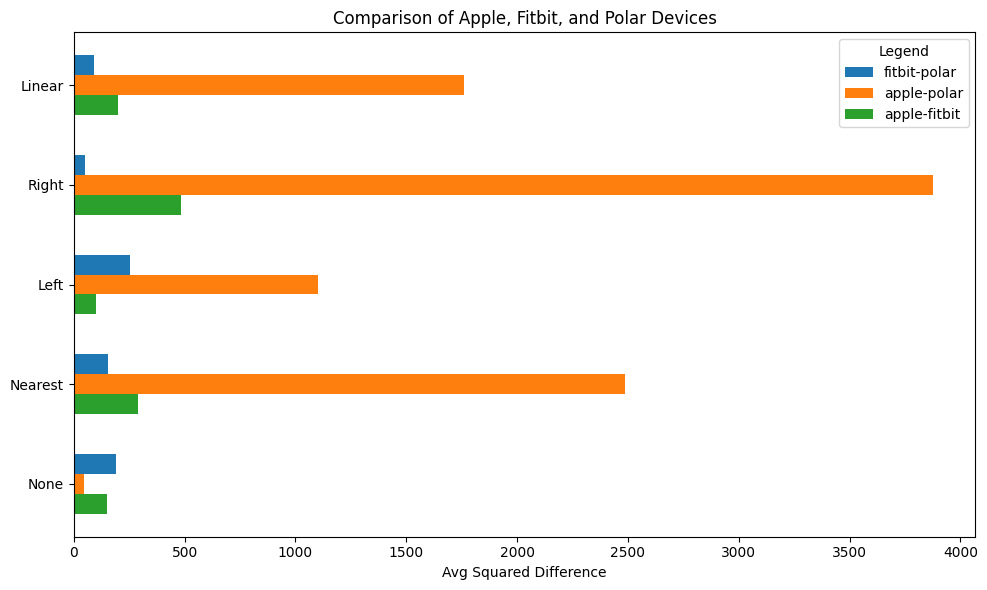

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['None', 'Nearest', 'Left', 'Right', 'Linear']  # Y axis
comparisons = ['apple-fitbit', 'apple-polar', 'fitbit-polar']  # Legend/Groups
data = np.random.rand(5, 3)  # Random data for avg squared difference (5 categories, 3 comparisons)
data = np.array([avgSqDiffNoInterps, avgSqDiffNearInterps, avgSqDiffPadInterps, avgSqDiffBfilInterps, avgSqDiffLinInterps])

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2  # Width of each bar
y_pos = np.arange(len(categories))  # Position for each category

# Plot each group of bars for comparisons
for i in range(len(comparisons) -1, -1, -1): # reversed to match legend order
    ax.barh(y_pos + i * bar_width, data[:, i], bar_width, label=comparisons[i])

# Add labels and titles
ax.set_yticks(y_pos + bar_width)  # Center Y-ticks
ax.set_yticklabels(categories)
ax.set_xlabel('Avg Squared Difference')
ax.set_title('Comparison of Apple, Fitbit, and Polar Devices')

# Add a legend for the comparisons
ax.legend(title="Legend", loc='best')

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
#find the longest overlapping interval that they all have data for
all_intersections_lengths = [g[1] - g[0] for g in all_intersections]
maxLenIndex = all_intersections_lengths.index(max(all_intersections_lengths))
print(f"the longest intersection is {all_intersections_lengths[maxLenIndex]} long from {all_intersections[maxLenIndex]}")

the longest intersection is 0 days 07:24:12 long from [Timestamp('2024-09-10 01:46:16-0700', tz='pytz.FixedOffset(-420)'), Timestamp('2024-09-10 09:10:28-0700', tz='pytz.FixedOffset(-420)')]


/home/chowder/Documents/dataImport/utils.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRDf["sampleDT"] = HRDf.index


the day has 5330 samples for apple in 1 groups


/home/chowder/Documents/dataImport/utils.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRDf["sampleDT"] = HRDf.index


the day has 3534 samples for fitbit in 1 groups


/home/chowder/Documents/dataImport/utils.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HRDf["sampleDT"] = HRDf.index


the day has 26649 samples for polar in 1 groups


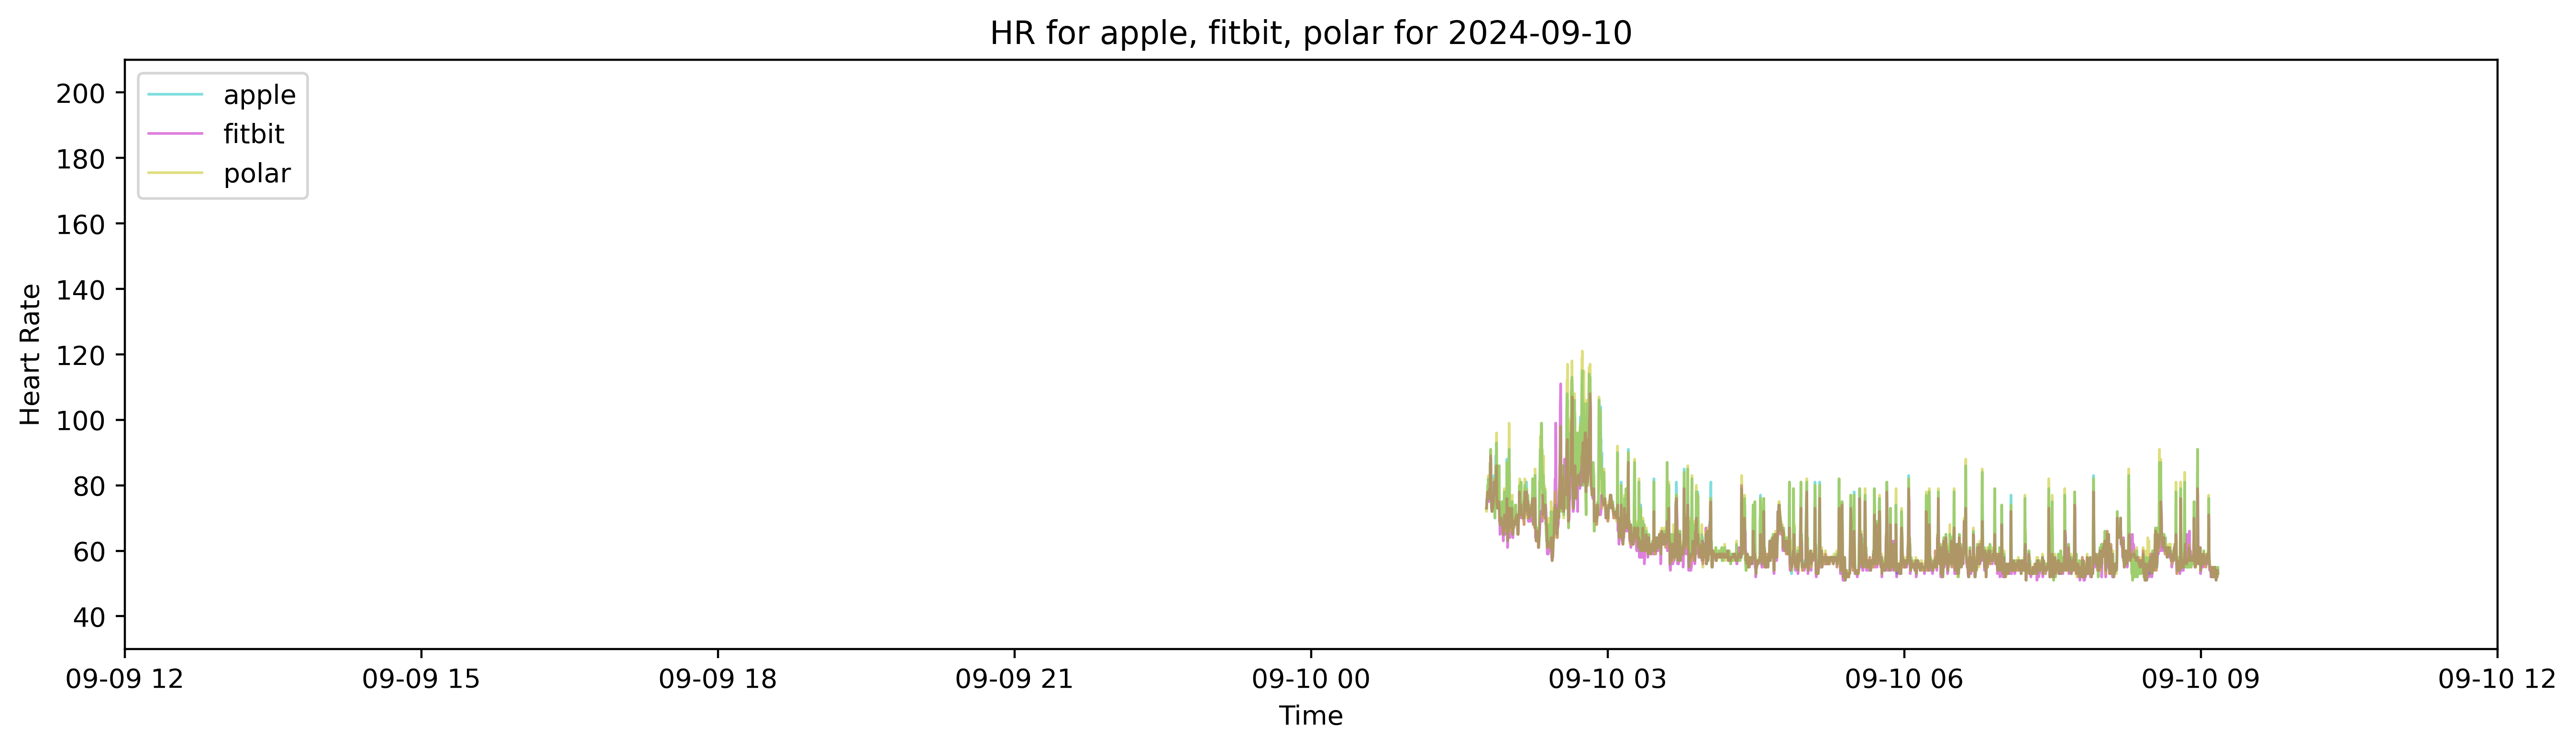

In [19]:
appleHRs = getHRsForTimePeriods(pd.DataFrame([all_intersections[maxLenIndex]], columns = ['startDate', 'endDate']), appleHRDf)
fitbitHRs = getHRsForTimePeriods(pd.DataFrame([all_intersections[maxLenIndex]], columns = ['startDate', 'endDate']), fitbitHRDf)
polarHRs = getHRsForTimePeriods(pd.DataFrame([all_intersections[maxLenIndex]], columns = ['startDate', 'endDate']), polarHRDf)
graphMultiHRDate([appleHRs, fitbitHRs, polarHRs], date(2024,9,10), ['apple', 'fitbit', 'polar'])

In [20]:
def prepForHRHR(intersectingGroups, HRDf1, HRDf2):
    intersectingGroupsDf =  pd.DataFrame(intersectingGroups, columns = ['startDate', 'endDate'])
    HRs1 = getHRsForTimePeriods(intersectingGroupsDf, HRDf1)
    HRs2 = getHRsForTimePeriods(intersectingGroupsDf, HRDf2)
    
    print(f"number of samples in each group {len(HRs1)} {len(HRs2)}")

    #for now lets just calc intersections with the same index using the join function
    intersectingHRs = HRs1.join(HRs2, how='inner', lsuffix="_1", rsuffix="_2")
    print(f"number of samples in common {len(intersectingHRs)}")
    return intersectingHRs

def prepForHRHRInterp(intersectingGroups, HRDf1, HRDf2, interpolationType):
    intersectingGroupsDf =  pd.DataFrame(intersectingGroups, columns = ['startDate', 'endDate'])
    HRs1 = getHRsForTimePeriods(intersectingGroupsDf, HRDf1)
    HRs2 = getHRsForTimePeriods(intersectingGroupsDf, HRDf2)

    HRs1Interp = HRs1.resample('1s').asfreq().interpolate(method=interpolationType)
    HRs2Interp = HRs2.resample('1s').asfreq().interpolate(method=interpolationType)
    
    print(f"number of samples in each group {len(HRs1Interp)} {len(HRs2Interp)}")

    #for now lets just calc intersections with the same index using the join function
    intersectingHRs = HRs1Interp.join(HRs2Interp, how='inner', lsuffix="_1", rsuffix="_2")
    print(f"number of samples in common {len(intersectingHRs)}")
    return intersectingHRs

number of samples in each group 96590 482868
number of samples in common 96562


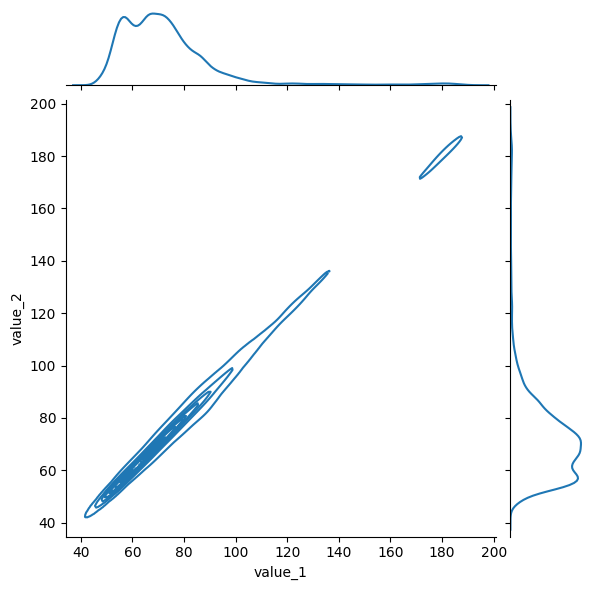

In [21]:
import seaborn as sns
apple_polar_comparisonDF = prepForHRHR(all_intersections, appleHRDf, polarHRDf)
ax = sns.jointplot(data = apple_polar_comparisonDF, x="value_1", y="value_2", kind="kde")

number of samples in each group 96590 482868
number of samples in common 96562


(30.0, 220.0)

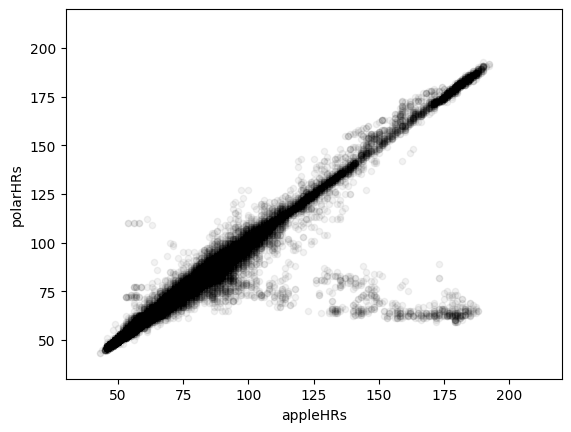

In [22]:
apple_polar_comparisonDF = prepForHRHR(all_intersections, appleHRDf, polarHRDf)
ax = apple_polar_comparisonDF.plot.scatter(x='value_1', y='value_2', color='k', alpha=.05)
ax.set_xlabel('appleHRs')
ax.set_ylabel('polarHRs')
ax.set_xlim([30,220])
ax.set_ylim([30,220])

number of samples in each group 70703 482868
number of samples in common 70679


(30.0, 220.0)

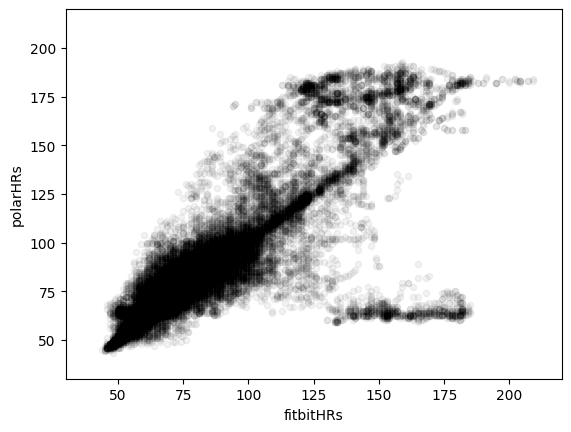

In [23]:
fitbit_polar_comparisonDF = prepForHRHR(all_intersections, fitbitHRDf, polarHRDf)
ax = fitbit_polar_comparisonDF.plot.scatter(x='value_1', y='value_2', color='k', alpha=.05)
ax.set_xlabel('fitbitHRs')
ax.set_ylabel('polarHRs')
ax.set_xlim([30,220])
ax.set_ylim([30,220])

number of samples in each group 16552142 16552146
number of samples in common 16552142


(30.0, 220.0)

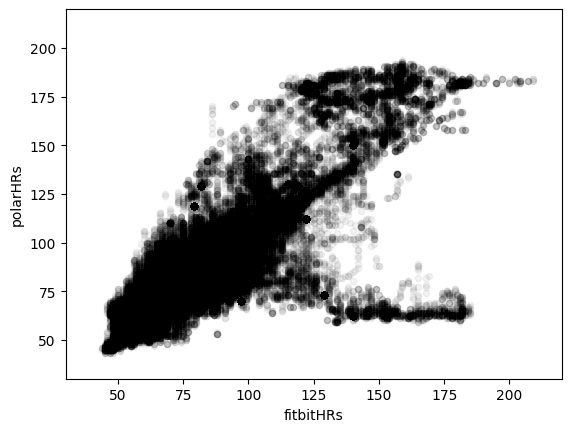

In [24]:
fitbit_polar_comparisonDF = prepForHRHRInterp(all_intersections, fitbitHRDf, polarHRDf, 'bfill')
ax = fitbit_polar_comparisonDF.plot.scatter(x='value_1', y='value_2', color='k', alpha=.05)
ax.set_xlabel('fitbitHRs')
ax.set_ylabel('polarHRs')
ax.set_xlim([30,220])
ax.set_ylim([30,220])

number of samples in each group 16552143 16552146
number of samples in common 16552143


(30.0, 220.0)

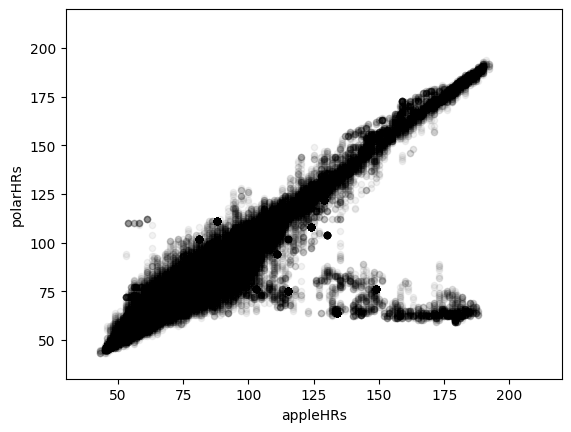

In [25]:
apple_polar_comparisonDF = prepForHRHRInterp(all_intersections, appleHRDf, polarHRDf, 'zero')
ax = apple_polar_comparisonDF.plot.scatter(x='value_1', y='value_2', color='k', alpha=.05)
ax.set_xlabel('appleHRs')
ax.set_ylabel('polarHRs')
ax.set_xlim([30,220])
ax.set_ylim([30,220])

number of samples in each group 16552143 16552146
number of samples in common 16552143


(30.0, 220.0)

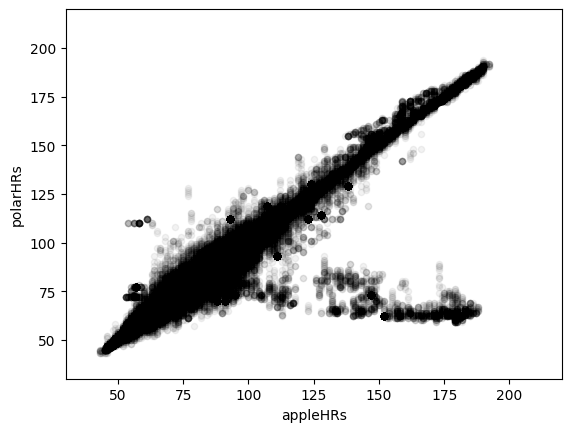

In [26]:
apple_polar_comparisonDF = prepForHRHRInterp(all_intersections, appleHRDf, polarHRDf, 'bfill')
ax = apple_polar_comparisonDF.plot.scatter(x='value_1', y='value_2', color='k', alpha=.05)
ax.set_xlabel('appleHRs')
ax.set_ylabel('polarHRs')
ax.set_xlim([30,220])
ax.set_ylim([30,220])

In [27]:
# this function takes a dataframe of type sampleDT index, value_1, value_2 
def HRHRplot(comparisonDF):
    pass

In [28]:
HRHRplot(apple_polar_comparisonDF)